In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-aac39ad0-6575-8679-1258-778a479f152e)


# Import Everything We Need

In [ ]:
# XGboost
from xgboost import XGBClassifier

# Graphs
import networkx as nx

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pytplot as plt

# Utils
from utils.utils import seed_everything, load_dataset_file, get_training_graph
from utils.utils import compute_matrix_similarity
from utils.features_extractor import compute_features

# Load Data

In [ ]:
# Features related to the texts
txt2feat = load_dataset_file('/content/drive/MyDrive/MLNS/data_generated/textmetafeatures.files')
# Features related to the nodes (node2vec)
node2vec_1 = load_dataset_file('/content/drive/MyDrive/MLNS/data_generated/n2v_graph_1.files')
node2vec_2 = load_dataset_file('/content/drive/MyDrive/MLNS/data_generated/n2v_graph_2.files')
node2vec_3 = load_dataset_file('/content/drive/MyDrive/MLNS/data_generated/n2v_graph_3.files')
# Data
df_train = pd.read_csv('/content/drive/MyDrive/MLNS/data/training_set.txt', sep=' ', header=None)
df_test = pd.read_csv('/content/drive/MyDrive/MLNS/data/testing_set.txt', sep=' ', header=None)
node_info = pd.read_csv('/content/drive/MyDrive/MLNS/data/node_information.csv', header=None, names=['node_id', 'date', 'title', 'authors', 'journal', 'abstract'])

# Graph Creation

In [ ]:
G = nx.DiGraph()
non_edges = []
for i in tqdm(range(len(df_train))):
  if df_train.iloc[i,2] == 1:
    G.add_edge(df_train.iloc[i,0], df_train.iloc[i,1])
  else:
    non_edges.append((df_train.iloc[i,0], df_train.iloc[i,1]))

for node in tqdm(node_info.node_id):
  if not (node in G.nodes()):
    G.add_node(node)

In [ ]:
print("There are", G.number_of_nodes(), "nodes")
print("There are", G.number_of_edges(), "edges")

There are 27770 nodes
There are 335130 edges


# Preprocessing

## Split in Train/Dev three times

In [ ]:
all_edges = list(G.edges())
non_edges_copy = non_edges.copy()

In [ ]:
seed = 42
seed_everything(seed)
np.random.shuffle(all_edges)
np.random.shuffle(non_edges_copy)

In [ ]:
print(f"Number of positive examples : {len(all_edges)}")
print(f"Number of negative examples : {len(non_edges_copy)}")

Number of positive examples : 335130
Number of negative examples : 280382


In [ ]:
number_pos_dev = int(0.06 * len(all_edges))
number_neg_dev = int(0.06 * len(non_edges_copy))
print(f"The number of pos examples : Dev {number_pos_dev} / Training {len(all_edges) - number_pos_dev}.")
print(f"The number of neg examples : Dev {number_neg_dev} / Training {len(non_edges_copy) - number_pos_dev}.")

The number of pos examples : Dev 20107 / Training 315023.
The number of neg examples : Dev 16822 / Training 260275.


In [ ]:
print(f"Proportion of positive example in data : {len(all_edges)/(len(all_edges) + len(non_edges_copy))}")
print(f"Proportion of positive example in training : {(len(all_edges) - number_pos_dev) / (len(all_edges) - number_pos_dev + len(non_edges_copy) - number_pos_dev)}")
print(f"Proportion of positive example in dev : {number_pos_dev/(number_pos_dev+number_neg_dev)}")

Proportion of positive example in data : 0.5444735439763969
Proportion of positive example in training : 0.5475822964793898
Proportion of positive example in dev : 0.5444772401093991


In [ ]:
pos_samples_dev_1 = all_edges[:number_pos_dev]
pos_samples_dev_2 = all_edges[number_pos_dev: 2*number_pos_dev]
pos_samples_dev_3 = all_edges[2*number_pos_dev: 3*number_pos_dev]
neg_samples_dev_1 = non_edges_copy[:number_neg_dev]
neg_samples_dev_2 = non_edges_copy[number_neg_dev: 2*number_neg_dev]
neg_samples_dev_3 = non_edges_copy[2*number_neg_dev: 3*number_neg_dev]

In [ ]:
assert len(pos_samples_dev_3) == len(pos_samples_dev_2) == len(pos_samples_dev_1)
assert len(neg_samples_dev_3) == len(neg_samples_dev_2) == len(neg_samples_dev_1)

In [ ]:
pos_samples_train_1 = list(set(all_edges) - set(pos_samples_dev_1))
pos_samples_train_2 = list(set(all_edges) - set(pos_samples_dev_2))
pos_samples_train_3 = list(set(all_edges) - set(pos_samples_dev_3))
neg_samples_train_1 = list(set(non_edges_copy) - set(neg_samples_dev_1))
neg_samples_train_2 = list(set(non_edges_copy) - set(neg_samples_dev_2))
neg_samples_train_3 = list(set(non_edges_copy) - set(neg_samples_dev_3))

## Slight Modification to the txt2feat
We will incoporate Journal even if we are missing values

In [ ]:
for idx, row in node_info.iterrows():
  node_id = row['node_id']
  if row['journal'] != row['journal']:
    txt2feat[node_id]['journal'] = None
  else:
    txt2feat[node_id]['journal'] = row['journal'].lower()
  if txt2feat[node_id]['authors']:
    txt2feat[node_id]['authors'] = [a.strip() for a in txt2feat[node_id]['authors']]

## Cosine Similarity

In [ ]:
paper_sim = compute_matrix_similarity(node_info.node_id, txt2feat)

## Graph Split Creation + PageRank + Katz

In [ ]:
graph_1 = get_training_graph(G, pos_samples_dev_1)
pr_1 = nx.pagerank(graph_1,alpha=0.85, max_iter=200)
katz_1 = nx.katz_centrality(graph_1)

graph_2 = get_training_graph(G, pos_samples_dev_2)
pr_2 = nx.pagerank(graph_2,alpha=0.85, max_iter=200)
katz_2 = nx.katz_centrality(graph_2)

graph_3 = get_training_graph(G, pos_samples_dev_3)
pr_3 = nx.pagerank(graph_3,alpha=0.85, max_iter=200)
katz_3 = nx.katz_centrality(graph_3)

# Model/Training

In [ ]:
# Node Mapping
node_mapping = {node: i for i,node in enumerate(node_info.node_id)}

## Split 1

In [ ]:
train_samples = pos_samples_train_1 + neg_samples_train_1
train_labels = [1 for x in pos_samples_train_1] + [0 for x in neg_samples_train_1]
dev_samples = pos_samples_dev_1 + neg_samples_dev_1
dev_labels = [1 for x in pos_samples_dev_1] + [0 for x in neg_samples_dev_1]

train_features = compute_features(graph_1, node2vec_1, txt2feat, train_samples, paper_sim, node_mapping, pr_1, katz_1)
dev_features = compute_features(graph_1, node2vec_1, txt2feat, dev_samples, paper_sim, node_mapping, pr_1, katz_1)

X_train = np.stack(train_features)
X_dev = np.stack(dev_features)

### Xgboost HyperParameters Finetuning

In [ ]:
n_estim = 2000
max_depth_candidates = [10, 15, 20]
learning_rates = [0.1, 0.05, 0.01]
min_child_weights = [1, 3, 4, 5]
best = 0.0
print(f"{'N_Estimators':^7} | {'Max_Depth':^7} | {'Min Child Weights':^7} | {'Learning_Rate':^7} | {'Accuracy':^12} | {'F1':^9} ")
for max_depth in tqdm(max_depth_candidates):
  for lr in learning_rates:
    for min_child_weight in min_child_weights:
      clf = XGBClassifier(max_depth=max_depth, learning_rate=lr, min_child_weight=min_child_weight, n_estimators=n_estim, n_jobs=4, tree_method='gpu_hist', predictor="gpu_predictor", random_state=42, seed=42)
      clf.fit(X_train, train_labels, eval_metric="auc", early_stopping_rounds=300, eval_set=[(X_dev, dev_labels)], verbose=0)
      y_pred = clf.predict(X_dev)
      acc = accuracy_score(dev_labels, y_pred)
      f1 = f1_score(dev_labels, y_pred)
      if f1 > best:
        best_params = (clf.best_ntree_limit, max_depth, lr, acc, f1)
        best = f1
      print(f"{clf.best_ntree_limit:^7} | {max_depth:^7} | {min_child_weight:^7} | {lr:^7} | {acc:^12} | {f1:^9}")
############
print()
print(f"Best Params:")
print(f"{best_params[0]:^7} | {best_params[1]:^7} | {best_params[2]:^7} | {best_params[3]:^12} | {best_params[4]:^9}")

N_Estimators | Max_Depth | Min Child Weights | Learning_Rate |   Accuracy   |    F1     


  59    |   10    |    1    |   0.1   | 0.9680738714831163 | 0.9702430529264785
  56    |   10    |    3    |   0.1   | 0.9680197135042921 | 0.9701985919402457
  55    |   10    |    4    |   0.1   | 0.9680197135042921 | 0.9702076133296336
  52    |   10    |    5    |   0.1   | 0.9678843185572314 | 0.9700671344202716
  126   |   10    |    1    |  0.05   | 0.9679384765360557 | 0.9701145943762935
  110   |   10    |    3    |  0.05   | 0.9676947656313466 | 0.9698988216889965
  110   |   10    |    4    |  0.05   | 0.9678301605784072 | 0.97002119713334
  109   |   10    |    5    |  0.05   | 0.9675052127054619 | 0.9697076791033473
  556   |   10    |    1    |  0.01   | 0.9681280294619404 | 0.9703010269738337
  564   |   10    |    3    |  0.01   | 0.9678572395678193 | 0.9700502106830167
  562   |   10    |    4    |  0.01   | 0.9678572395678193 | 0.9700441640378549
  541   |   10    |    5    |  0.01   | 0.9678843185572314 | 0.9700656234225139
  74    |   15    |    1    |   0.1   | 0.

In [ ]:
clf_1 = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=2000, n_jobs=4, tree_method='gpu_hist', predictor="gpu_predictor", random_state=42, seed=42)
clf_1.fit(X_train, train_labels, eval_metric="auc", early_stopping_rounds=300, eval_set=[(X_dev, dev_labels)], verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=4,
              nthread=None, objective='binary:logistic',
              predictor='gpu_predictor', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
              subsample=1, tree_method='gpu_hist', verbosity=1)

### Probability

In [ ]:
y_proba = clf_1.predict_proba(X_dev)

0.9917153016169108
Threshold value is: 0.39318317


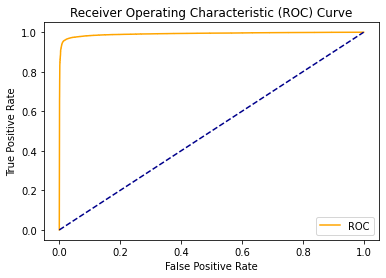

In [ ]:
fpr, tpr, thresholds = roc_curve(dev_labels, y_proba[:,1])
print(roc_auc_score(dev_labels, y_proba[:,1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

## Split 2

In [ ]:
train_samples = pos_samples_train_2 + neg_samples_train_2
train_labels = [1 for x in pos_samples_train_2] + [0 for x in neg_samples_train_2]
dev_samples = pos_samples_dev_2 + neg_samples_dev_2
dev_labels = [1 for x in pos_samples_dev_2] + [0 for x in neg_samples_dev_2]

train_features = compute_features(graph_2, node2vec_2, txt2feat, train_samples, paper_sim, node_mapping, pr_2, katz_2)
dev_features = compute_features(graph_2, node2vec_2, txt2feat, dev_samples, paper_sim, node_mapping, pr_2, katz_2)

X_train = np.stack(train_features)
X_dev = np.stack(dev_features)

### Xgboost HyperParameters Finetuning

In [ ]:
n_estim = 2000
max_depth_candidates = [10, 15, 20]
learning_rates = [0.1, 0.05, 0.01]
min_child_weights = [1, 3, 4, 5]
best = 0.0
print(f"{'N_Estimators':^7} | {'Max_Depth':^7} | {'Min Child Weights':^7} | {'Learning_Rate':^7} | {'Accuracy':^12} | {'F1':^9} ")
for max_depth in tqdm(max_depth_candidates):
  for lr in learning_rates:
    for min_child_weight in min_child_weights:
      clf = XGBClassifier(max_depth=max_depth, learning_rate=lr, min_child_weight=min_child_weight, n_estimators=n_estim, n_jobs=4, tree_method='gpu_hist', predictor="gpu_predictor", random_state=42, seed=42)
      clf.fit(X_train, train_labels, eval_metric="auc", early_stopping_rounds=300, eval_set=[(X_dev, dev_labels)], verbose=0)
      y_pred = clf.predict(X_dev)
      acc = accuracy_score(dev_labels, y_pred)
      f1 = f1_score(dev_labels, y_pred)
      if f1 > best:
        best_params = (clf.best_ntree_limit, max_depth, min_child_weight, lr, acc, f1)
        best = f1
      print(f"{clf.best_ntree_limit:^7} | {max_depth:^7} | {min_child_weight:^7} | {lr:^7} | {acc:^12} | {f1:^9}")
############
print()
print(f"Best Params:")
print(f"{best_params[0]:^7} | {best_params[1]:^7} | {best_params[2]:^7} | {best_params[3]:^7} | {best_params[4]:^12} | {best_params[5]:^9}")

N_Estimators | Max_Depth | Min Child Weights | Learning_Rate |   Accuracy   |    F1     


  165   |    3    |    1    |   0.1   | 0.9642286549865959 | 0.9664320382181791
  151   |    3    |    3    |   0.1   | 0.9640932600395353 | 0.966305839304772
  120   |    3    |    4    |   0.1   | 0.9641744970077717 | 0.9663726711231986
  139   |    3    |    5    |   0.1   | 0.9643369709442443 | 0.9665319813981854
  310   |    3    |    1    |  0.05   | 0.9642828129654202 | 0.9664879697146777
  285   |    3    |    3    |  0.05   | 0.9643098919548323 | 0.9665057179161373
  323   |    3    |    4    |  0.05   | 0.9643098919548323 | 0.9665176303221216
  341   |    3    |    5    |  0.05   | 0.9644723658913049 | 0.9666683603475433
 1469   |    3    |    1    |  0.01   | 0.9640932600395353 | 0.9663075515804451
 1462   |    3    |    3    |  0.01   | 0.9641744970077717 | 0.9663829246601449
 1503   |    3    |    4    |  0.01   | 0.9641744970077717 | 0.9663846329750744
 1521   |    3    |    5    |  0.01   | 0.9642286549865959 | 0.966437155415534
  82    |    5    |    1    |   0.1   | 0.

In [ ]:
clf_2 = XGBClassifier(max_depth=15, learning_rate=0.1, min_child_weight=3, n_estimators=2000, n_jobs=4, tree_method='gpu_hist', predictor="gpu_predictor", random_state=42, seed=42)
clf_2.fit(X_train, train_labels, eval_metric="auc", early_stopping_rounds=300, eval_set=[(X_dev, dev_labels)], verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=2000, n_jobs=4,
              nthread=None, objective='binary:logistic',
              predictor='gpu_predictor', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
              subsample=1, tree_method='gpu_hist', verbosity=1)

### Probability

In [ ]:
y_proba = clf_2.predict_proba(X_dev)

0.9915375845870651
Threshold value is: 0.29895467


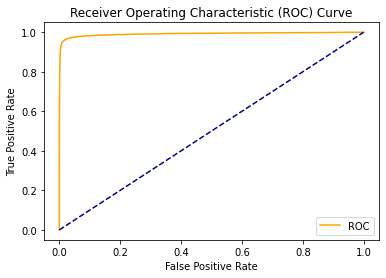

In [ ]:
fpr, tpr, thresholds = roc_curve(dev_labels, y_proba[:,1])
print(roc_auc_score(dev_labels, y_proba[:,1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

## Split 3

In [ ]:
train_samples = pos_samples_train_3 + neg_samples_train_3
train_labels = [1 for x in pos_samples_train_3] + [0 for x in neg_samples_train_3]
dev_samples = pos_samples_dev_3 + neg_samples_dev_3
dev_labels = [1 for x in pos_samples_dev_3] + [0 for x in neg_samples_dev_3]

train_features = compute_features(graph_3, node2vec_3, txt2feat, train_samples, paper_sim, node_mapping, pr_3, katz_3)
dev_features = compute_features(graph_3, node2vec_3, txt2feat, dev_samples, paper_sim, node_mapping, pr_3, katz_3)

X_train = np.stack(train_features)
X_dev = np.stack(dev_features)

### Xgboost HyperParameters Finetuning

In [ ]:
n_estim = 2000
max_depth_candidates = [10, 15, 20]
learning_rates = [0.1, 0.05, 0.01]
min_child_weights = [1, 3, 4, 5]
best = 0.0
print(f"{'N_Estimators':^7} | {'Max_Depth':^7} | {'Min Child Weights':^7} | {'Learning_Rate':^7} | {'Accuracy':^12} | {'F1':^9} ")
for max_depth in tqdm(max_depth_candidates):
  for lr in learning_rates:
    for min_child_weight in min_child_weights:
      clf = XGBClassifier(max_depth=max_depth, learning_rate=lr, min_child_weight=min_child_weight, n_estimators=n_estim, n_jobs=4, tree_method='gpu_hist', predictor="gpu_predictor", random_state=42, seed=42)
      clf.fit(X_train, train_labels, eval_metric="auc", early_stopping_rounds=300, eval_set=[(X_dev, dev_labels)], verbose=0)
      y_pred = clf.predict(X_dev)
      acc = accuracy_score(dev_labels, y_pred)
      f1 = f1_score(dev_labels, y_pred)
      if f1 > best:
        best_params = (clf.best_ntree_limit, max_depth, min_child_weight, lr, acc, f1)
        best = f1
      print(f"{clf.best_ntree_limit:^7} | {max_depth:^7} | {min_child_weight:^7} | {lr:^7} | {acc:^12} | {f1:^9}")
############
print()
print(f"Best Params:")
print(f"{best_params[0]:^7} | {best_params[1]:^7} | {best_params[2]:^7} | {best_params[3]:^7} | {best_params[4]:^12} | {best_params[5]:^9}")

N_Estimators | Max_Depth | Min Child Weights | Learning_Rate |   Accuracy   |    F1     


  333   |    3    |    1    |   0.1   | 0.9636599962089415 | 0.9659615482169126
  290   |    3    |    3    |   0.1   | 0.9637141541877657 | 0.9660071029934044
  303   |    3    |    4    |   0.1   | 0.9637953911560021 | 0.9660840668679131
  251   |    3    |    5    |   0.1   | 0.9636870751983536 | 0.9659636031371355
  563   |    3    |    1    |  0.05   | 0.963551680251293 | 0.9658375634517767
  684   |    3    |    3    |  0.05   | 0.9636058382301173 | 0.9658917876357731
  564   |    3    |    4    |  0.05   | 0.9634975222724688 | 0.9657815911052444
  588   |    3    |    5    |  0.05   | 0.9638224701454142 | 0.9660913705583757
 1979   |    3    |    1    |  0.01   | 0.9631184164206992 | 0.9654033732981101
 1994   |    3    |    3    |  0.01   | 0.9632538113677598 | 0.9655260015750832
 1984   |    3    |    4    |  0.01   | 0.9633621273254083 | 0.9656293661882382
 1993   |    3    |    5    |  0.01   | 0.9632538113677598 | 0.9655312555564022
  162   |    5    |    1    |   0.1   | 0

In [ ]:
clf_3 = XGBClassifier(max_depth=10, learning_rate=0.1, min_child_weight=4, n_estimators=2000, n_jobs=4, tree_method='gpu_hist', predictor="gpu_predictor", random_state=42, seed=42)
clf_3.fit(X_train, train_labels, eval_metric="auc", early_stopping_rounds=300, eval_set=[(X_dev, dev_labels)], verbose=0)

### Probability

In [ ]:
y_proba = clf_3.predict_proba(X_dev)

0.9925835653939332
Threshold value is: 0.39055103


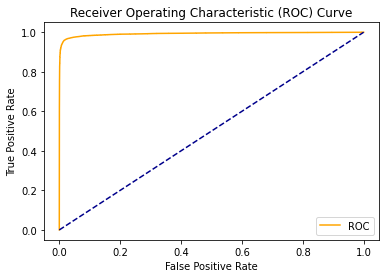

In [ ]:
fpr, tpr, thresholds = roc_curve(dev_labels, y_proba[:,1])
print(roc_auc_score(dev_labels, y_proba[:,1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

# Submission Time

In [ ]:
test_features_1 = compute_features(graph_1, node2vec_1, txt2feat, df_test[[0,1]].values.tolist(), paper_sim, node_mapping, pr_1, katz_1)
X_test = np.stack(test_features_1)
y_pred_1 = clf_1.predict_proba(X_test)[:,1]
test_features_2 = compute_features(graph_2, node2vec_2, txt2feat, df_test[[0,1]].values.tolist(), paper_sim, node_mapping, pr_2, katz_2)
X_test = np.stack(test_features_2)
y_pred_2 = clf_2.predict_proba(X_test)[:,1]
test_features_3 = compute_features(graph_3, node2vec_3, txt2feat, df_test[[0,1]].values.tolist(), paper_sim, node_mapping, pr_3, katz_3)
X_test = np.stack(test_features_3)
y_pred_3 = clf_3.predict_proba(X_test)[:,1]

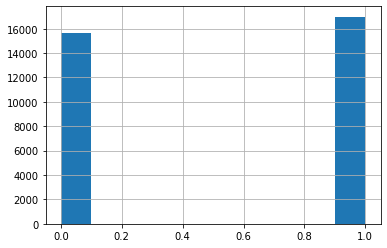

In [ ]:
y_proba = (y_pred_1 + y_pred_2 + y_pred_3)/3

threshold = 0.3
y_pred_final = np.where(y_proba >= threshold, 1, 0)

df_sub = pd.read_csv('/content/drive/MyDrive/MLNS/data/random_predictions.csv')
df_sub['category'] = y_pred_final

df_sub.category.hist()

In [ ]:
df_sub.to_csv('/content/drive/MyDrive/MLNS/submissions_xgboost_ensemble.csv', index=False)